<a href="https://colab.research.google.com/github/bensenberner/airline-sentiment-prediction/blob/master/notebooks/Airline_Rebalanced.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
%matplotlib inline

In [1]:
from fastai.text import *
from fastai.callbacks import *
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report
import pandas as pd
data_path = 'drive/My Drive/airline-sentiment'
bs=24

# need to set a bunch of random seeds to ensure reproducibility
seed=42
import numpy
numpy.random.seed(seed)
import os
os.environ['PYTHONHASHSEED']=str(seed)
import random
random.seed(seed)
import torch
if torch.cuda.is_available(): 
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed) # gpu vars
    torch.backends.cudnn.deterministic = True  #needed
    torch.backends.cudnn.benchmark = False

See EDA notebook in [notebooks/Data.ipynb](https://github.com/bensenberner/airline-sentiment-prediction) to learn about how the data was generated. (specifically the section on oversampling)

# Language Model

[Needed](https://github.com/fastai/fastai/blob/master/fastai/callbacks/oversampling.py#L17) to cast the labels to ints

In [2]:
lm_data = (
    TextList
    .from_csv(data_path, 'oversampled_train_text.csv')
    .split_by_rand_pct(0.1, seed=seed)
    .label_for_lm()
    .databunch(bs=bs)
)
lm_data.train_dl.y.items = lm_data.train_dl.y.items.astype(np.int64)
lm_data.valid_dl.y.items = lm_data.valid_dl.y.items.astype(np.int64)
lm_data.c = 3
lm_data.save('lm_data')

In [ ]:
lm_data = load_data(data_path, 'lm_data')

In [3]:
lm_data.show_batch()

idx,text
0,"yesterday . xxmaj confirmed upgrade & & carry on , got to counter & & manager upgraded somebody else on my seat ! xxbos @united we have tried to change our flight xxup three times on the phone and got disconnected each time . xxbos xxmaj decisions xxmaj decisions @mandarinjourney @united : xxmaj we 'd love for you to try our service . xxmaj we offer status match too ."
1,", nothing happened xxbos @southwestair awesome . thank you ! xxbos @southwestair there really should not be guidance to call via phone if you are that back logged . i could have done it online in 3 minutes . xxbos @virginamerica ... xxmaj please come to xxmaj minneapolis xxmaj st. xxmaj xxunk ! xxbos @usairways i spent more on the room & & transportation then i did the whole flight"
2,"flights , nothing . xxmaj is this a policy or not ? xxbos @jetblue keeps asking me to enter a valid email address . xxmaj my info is saved and has worked hundreds of times before xxbos @united says @usairways is the final carrier . xxmaj us air does nt have it . i want my bag ! ! ! xxmaj not a claim not an i m sorry ."
3,xxmaj card in xxup xxunk only to be told xxmaj star xxmaj alliance is n't accepted xxbos @usairways what is happening with flight 1701 from xxup bos to xxup phl ? xxmaj daughter and her xxunk are stuck in xxup bos ! xxbos @americanair it 's not cool that my flight was xxmaj cancelled xxmaj flightled after sitting on the plane for over an hour . 👎 😡 ✈ ️
4,"you recommend ? xxbos @usairways xxup us 728 . xxmaj nope , not getting off . 3 hours in the plane . 4 pilot announcements . xxmaj one water run of the planet 's smallest water bottles . xxbos @united wins top marks for customer service via xxmaj twitter . xxmaj they turned a poor experience into a positive . xxmaj many thanks for the effort ! 👍 xxbos @jetblue"


In [4]:
lm = language_model_learner(lm_data, AWD_LSTM, drop_mult=0.3) # drop_mult taken from fast.ai course v3

epoch,train_loss,valid_loss,accuracy,time


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.
Min numerical gradient: 2.75E-02
Min loss divided by 10: 4.37E-02


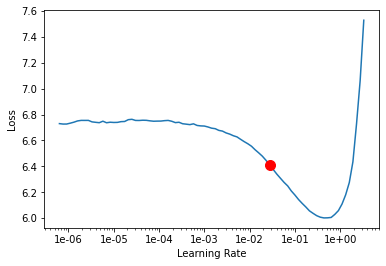

In [5]:
lm.lr_find()
lm.recorder.plot(suggestion=True)

In [6]:
init_lr = 4.37e-02

In [7]:
lm.fit_one_cycle(1, init_lr, moms=(0.8, 0.7))
lm.save('1_airline_lm')

epoch,train_loss,valid_loss,accuracy,time
0,3.618759,3.349268,0.339146,00:19


In [ ]:
lm.load('1_airline_lm')

Now that I've saved the language model, I can go back and try different values for `cyc_len`.

In [9]:
lm.unfreeze()
lm.fit_one_cycle(6, init_lr * 0.1, moms=(0.8, 0.7))
lm.save('2_airline_oversampled_lm')
lm.save_encoder('2_airline_oversampled_enc')

epoch,train_loss,valid_loss,accuracy,time
0,2.886364,2.869778,0.426523,00:24
1,2.506769,2.533140,0.494608,00:24
2,2.067433,2.249550,0.560714,00:24
3,1.611242,2.112283,0.599895,00:24
4,1.156375,2.114504,0.616211,00:24
5,0.885129,2.168577,0.617700,00:24


In [10]:
text = "My flight was cancelled due"
n_words = 40
n_sentences = 5
print("\n".join(lm.predict(text, n_words, temperature=0.8) for _ in range(n_sentences)))

My flight was cancelled due to weather in RDU ... Another weather delay but the pilot does n't get the weather seriously ? ? ? xxbos @virginamerica i ’m looking forward to watching the Oscars on my flight home tomorrow . i
My flight was cancelled due to weather in Dallas 2 / 17 the next flight in Phoenix RT @jetblue : Our fleet 's on fleek . http : / / t.co / hp9rppcvhx xxbos @southwestair i am concerned that you need
My flight was cancelled due to weather in Dallas , NC . That 's not the issue . Can you help ! ? Save me some peanuts xxbos @americanair volumes , profit up http : / / t.co / pkfi9bttzf
My flight was cancelled due to weather in STL . The ONLY airline was Late Flight to new flight . You got us to MCO . Wo n't let me on on the plane . Get
My flight was cancelled due to weather in Newark , NJ and i ' hangs up on you . Pls hold US1765 for me . Are you going to get me home ? UNACCEPTABLE xxbos @southwestair Thank you


Now that all the sentiments are equally likely, these tweets seem very confused. They change mood mid tweeet. "UNACCEPTABLE @southwest air Thank you". It's also mixing updates from the airlines with tweets from the customers to the airlines.

# Train classifier using oversampled airline data




In [11]:
cls_data = (
    TextList
    .from_csv(data_path, 'oversampled_train.csv', cols='text')
    .split_by_rand_pct(0.1, seed=seed)
    .label_from_df(cols=0)
    .databunch(bs=bs, num_workers=0)
)
cls_data.save('oversampled_cls_data_1.pkl')

In [4]:
cls_data = load_data(data_path, 'oversampled_cls_data_1.pkl')

Load the LM encoder, this will be used to create embeddings for the classifier. `drop_mult=0.5` taken from the fast.ai text tutorial

In [ ]:
cls = text_classifier_learner(cls_data, AWD_LSTM, drop_mult=0.5)
cls.load_encoder('2_airline_oversampled_enc')

epoch,train_loss,valid_loss,accuracy,time


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.
Min numerical gradient: 3.63E-03
Min loss divided by 10: 3.02E-02


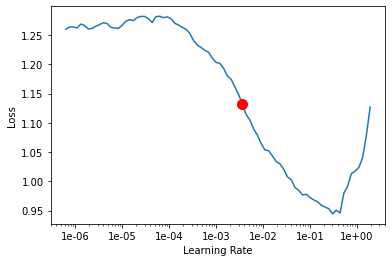

In [13]:
cls.lr_find()
cls.recorder.plot(suggestion=True)

In [14]:
init_cls_lr = 3e-2
cls.fit_one_cycle(1, init_cls_lr, moms=(0.8, 0.7))
cls.save('1_cls')

epoch,train_loss,valid_loss,accuracy,time
0,0.520488,0.467855,0.813005,00:13


In [ ]:
cls.load('1_cls')

To prevent catastrophic forgetting, we freeze all but the last couple of layers

In [15]:
cls.freeze_to(-2)
# 2.6**4 is a magic number for determining the minimum learning rate. Derived from
# https://course.fast.ai/videos/?lesson=4 @ 33:45
cls.fit_one_cycle(1, slice(init_cls_lr/(2.6**4), init_cls_lr), moms=(0.8,0.7))
cls.save('2_cls')

epoch,train_loss,valid_loss,accuracy,time
0,0.431307,0.385465,0.861470,00:15


Following the pattern from the ULMFiT paper, we now decrease the max (and min) learning rates before continuing to train on more unfrozen layers.

In [ ]:
cls.save('2_cls')

In [16]:
cls.freeze_to(-3)
new_cls_lr = init_cls_lr * 0.1
cls.fit_one_cycle(1, slice(new_cls_lr / (2.6**4), new_cls_lr), moms=(0.8, 0.7))
cls.save('3_cls')

epoch,train_loss,valid_loss,accuracy,time
0,0.299452,0.286509,0.896204,00:24


In [ ]:
cls.load('3_cls')

In [17]:
cls.unfreeze()
cls.fit_one_cycle(7, slice(new_cls_lr / (2.6**4), new_cls_lr), moms=(0.8,0.7))
cls.save('4_oversampled_cls')

epoch,train_loss,valid_loss,accuracy,time
0,0.263074,0.264736,0.911551,00:31
1,0.193446,0.211673,0.937399,00:32
2,0.166569,0.176275,0.945880,00:30
3,0.123961,0.169685,0.948304,00:33
4,0.096787,0.164157,0.952746,00:33
5,0.067010,0.167891,0.959612,00:31
6,0.066207,0.167485,0.954766,00:33


Accuracy is MUCH higher than it was on the imbalanced data!! It really seems to have figured out how to recognize all the classes, even the ones that were previously minority classes! Let's test it out and see how it did.

In [18]:
cls.export('4_oversampled_cls')

In [19]:
cls.predict("Your customer service is awful, you should be ashamed of yourselves. Never flying again")

(Category tensor(0), tensor(0), tensor([9.9997e-01, 4.5835e-06, 2.1923e-05]))

In [20]:
cls.predict("Thank you very much for helping me. I'm definitely flying with you again!")

(Category tensor(2), tensor(2), tensor([4.7682e-05, 1.7246e-04, 9.9978e-01]))

In [23]:
cls.predict("How do I check in to my flight?")

(Category tensor(1), tensor(1), tensor([0.3261, 0.6725, 0.0014]))

Wow! MUCH more confident than it was before!

## See [this notebook](https://colab.research.google.com/drive/1P7-Om6yWwzliZUIepo7ftuRrYAkEGeDr) to learn how well this model performed on the test set